Pares encontrados: 3
2023-08-08 19.38.42-1_seg_001.png: píxeles por cluster = [2381, 7083, 504]


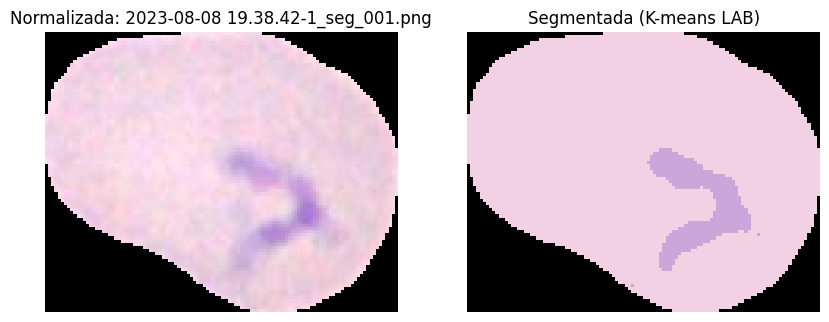

2023-08-08 19.38.42-1_seg_003.png: píxeles por cluster = [2428, 475, 8397]


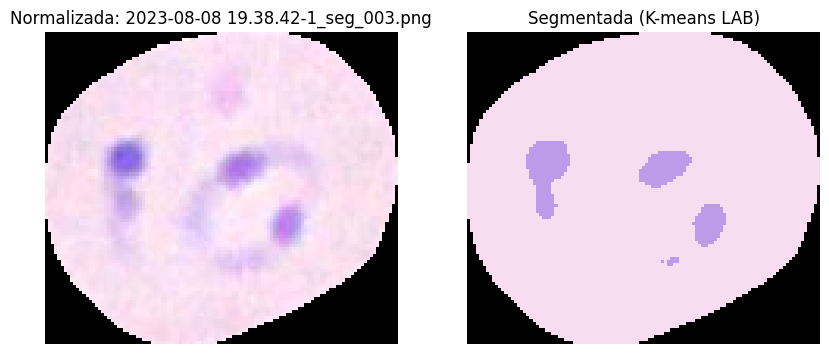

2023-08-08 19.38.42-1_seg_000.png: píxeles por cluster = [6063, 1540, 2000]


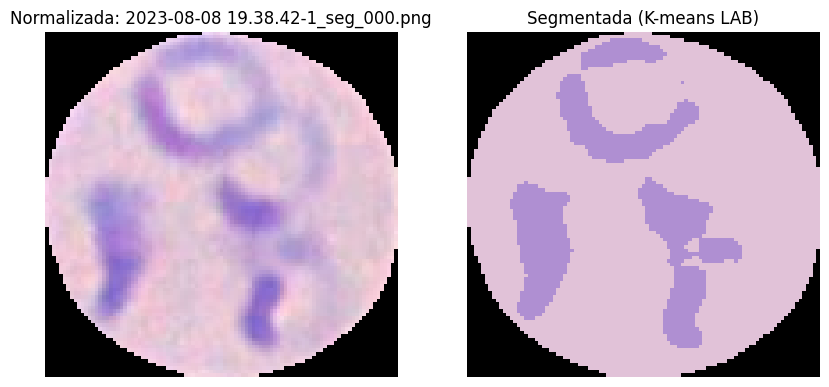

In [5]:
from pathlib import Path
import numpy as np
import cv2
from skimage import color as skcolor, img_as_ubyte
import matplotlib.pyplot as plt
import glob, os

def read_rgb_float01(path: str):
    """cv2.imread -> RGB float32 en [0,1]"""
    arr = cv2.imread(path, cv2.IMREAD_COLOR)
    if arr is None:
        raise FileNotFoundError(f"No se puede leer: {path}")
    arr = cv2.cvtColor(arr, cv2.COLOR_BGR2RGB)
    return (arr.astype(np.float32) / 255.0)

def normalize_img(img: np.ndarray, rimg: np.ndarray, eps: float = 1e-8) -> np.ndarray:
    norm = img / (rimg + eps)
    norm = np.nan_to_num(norm, nan=0.0, posinf=0.0, neginf=0.0)
    return np.clip(norm, 0.0, 1.0).astype(np.float32)

def kmeans_lab_segments(rgb_float: np.ndarray, K: int = 3, max_iter: int = 60, attempts: int = 20):
    """RGB[0,1] -> LAB, k-means en LAB, devuelve labels, centers y la imagen segmentada en LAB"""
    lab = skcolor.rgb2lab(rgb_float)
    h, w, _ = lab.shape
    samples = lab.reshape((-1, 3)).astype(np.float32)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, max_iter, 1.0)
    compactness, labels, centers = cv2.kmeans(samples, K, None, criteria, attempts, cv2.KMEANS_RANDOM_CENTERS)
    labels = labels.flatten()
    segmented_lab = centers[labels].reshape((h, w, 3))
    return labels, centers, segmented_lab

# --- Rutas ---
root = "./img"  # ajusta la carpeta si es necesario
pairs = []
for ref_path in Path(root).rglob("*_ref.png"):
    img_path = Path(str(ref_path).replace("_ref.png", ".png"))
    if img_path.exists():
        pairs.append((img_path, ref_path))

print(f"Pares encontrados: {len(pairs)}")

# --- Proceso ---
for (img_path, ref_path) in pairs:
    img  = read_rgb_float01(str(img_path))
    rimg = read_rgb_float01(str(ref_path))
    norm_img = normalize_img(img, rimg)

    labels, centers, seg_lab = kmeans_lab_segments(norm_img, K=3)
    seg_rgb = skcolor.lab2rgb(seg_lab)

    # Conteo de píxeles por clúster:
    counts = np.bincount(labels, minlength=centers.shape[0])
    print(f"{img_path.name}: píxeles por cluster = {counts.tolist()}")

    # Guardar resultado
    out_path = Path(root) / f"{img_path.stem}_seg.png"
    cv2.imwrite(str(out_path), cv2.cvtColor(img_as_ubyte(seg_rgb), cv2.COLOR_RGB2BGR))

    # --- Mostrar en pantalla ---
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(norm_img)
    plt.title(f"Normalizada: {img_path.name}")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(seg_rgb)
    plt.title("Segmentada (K-means LAB)")
    plt.axis("off")
    plt.show()